In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # Removed from model and added here
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # See seq_to_seq.ipynb for explanation
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

**Note:** We've removed the first lambda layer to add a dimension in our model. Instead we've added it to windowed_dataset() above. We now specify the input shape in Conv1D, i.e, the third dimension is 1 for univariate.

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 73.1912 - mae: 73.6904 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 72.4799 - mae: 72.9791 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 71.3446 - mae: 71.8437 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 69.9230 - mae: 70.4223 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 68.2678 - mae: 68.7669 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 66.3621 - mae: 66.8609 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 64.2432 - mae: 64.7424 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 61.8749 - mae: 62.3738 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 59.2491 - mae: 59.7479 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

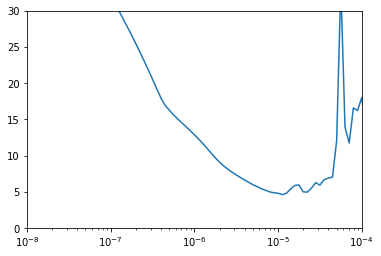

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 9ms/step - loss: 27.3278 - mae: 27.8236
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 10.4005 - mae: 10.8894
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.7115 - mae: 8.1960
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 6.8613 - mae: 7.3439
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 6.3387 - mae: 6.8205
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 5.9785 - mae: 6.4595
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 5.6776 - mae: 6.1572
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 5.5133 - mae: 5.9932
Epoch 9/500
31/31 [==============================] - 0s 8ms/step - loss: 5.3457 - mae: 5.8250
Epoch 10/500
31/31 [==============================] - 0s 7ms/step - loss: 5.2780 - mae: 5.7576
Epoch 11/500
31/31 [==============================] - 0

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

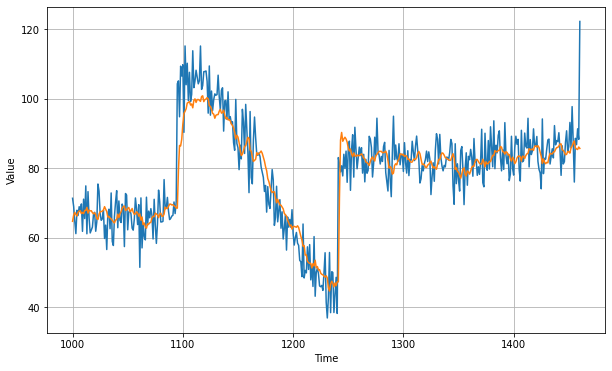

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.9307866

<Figure size 432x288 with 0 Axes>

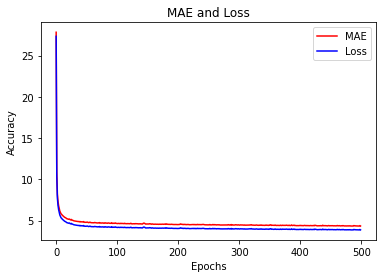

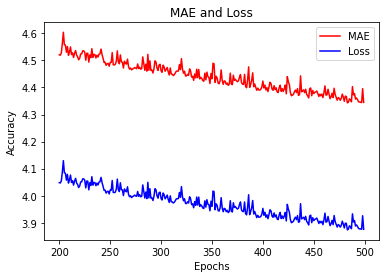

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

**Note:** If we make the LSTMs bidirectional, the loss and accuracy are lower but the curve doesn't fit the validation set any better. In fact, the MAE is higher! This means that we are *overfitting*.

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 12ms/step - loss: 35.3988 - mae: 35.8957
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 8.6564 - mae: 9.1425
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 6.0446 - mae: 6.5251
Epoch 4/500
31/31 [==============================] - 0s 12ms/step - loss: 4.9293 - mae: 5.4061
Epoch 5/500
31/31 [==============================] - 0s 11ms/step - loss: 4.5141 - mae: 4.9903
Epoch 6/500
31/31 [==============================] - 0s 12ms/step - loss: 4.6605 - mae: 5.1377
Epoch 7/500
31/31 [==============================] - 0s 11ms/step - loss: 4.4597 - mae: 4.9362
Epoch 8/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0614 - mae: 4.5356
Epoch 9/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9545 - mae: 4.4280
Epoch 10/500
31/31 [==============================] - 0s 11ms/step - loss: 4.1878 - mae: 4.6626
Epoch 11/500
31/31 [===========================

7.819816

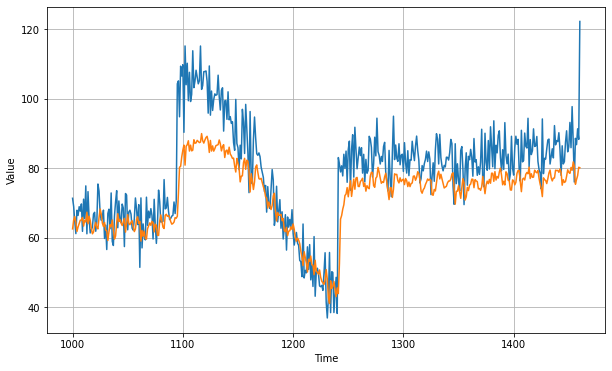

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

**Pro tip:** When we plot the MAE and loss curves, we see a lot of noise. This happens due to small batch sizes which increase the randomness and therefore the noise. Adjusting the batch size can help fix this issue.

<Figure size 432x288 with 0 Axes>

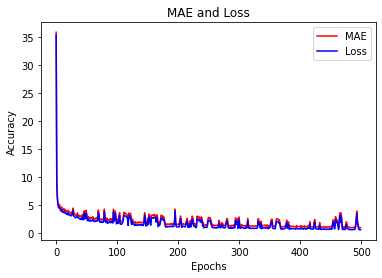

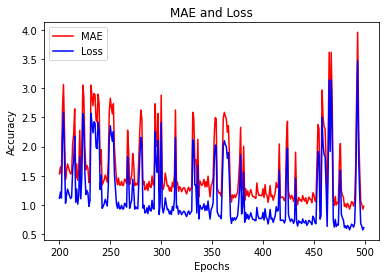

<Figure size 432x288 with 0 Axes>

In [17]:

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

**Note:** We now go back to regular LSTMs (not bidirectional) and try a batch size of 64 to see the impact on the model. We see that the forecast fits the actual more closely with lower MAE.

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
61/61 [==============================] - 0s 8ms/step - loss: 18.0446 - mae: 18.5362
Epoch 2/500
61/61 [==============================] - 0s 6ms/step - loss: 7.4095 - mae: 7.8932
Epoch 3/500
61/61 [==============================] - 0s 6ms/step - loss: 6.3225 - mae: 6.8037
Epoch 4/500
61/61 [==============================] - 0s 6ms/step - loss: 5.7030 - mae: 6.1826
Epoch 5/500
61/61 [==============================] - 0s 8ms/step - loss: 5.3396 - mae: 5.8188
Epoch 6/500
61/61 [==============================] - 0s 6ms/step - loss: 5.1396 - mae: 5.6184
Epoch 7/500
61/61 [==============================] - 0s 7ms/step - loss: 5.0318 - mae: 5.5102
Epoch 8/500
61/61 [==============================] - 0s 7ms/step - loss: 4.9001 - mae: 5.3782
Epoch 9/500
61/61 [==============================] - 0s 7ms/step - loss: 4.7927 - mae: 5.2707
Epoch 10/500
61/61 [==============================] - 0s 7ms/step - loss: 4.7857 - mae: 5.2634
Epoch 11/500
61/61 [==============================] - 0s 

5.1595645

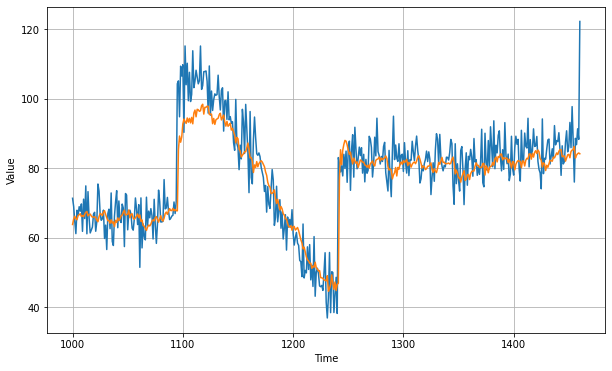

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

<Figure size 432x288 with 0 Axes>

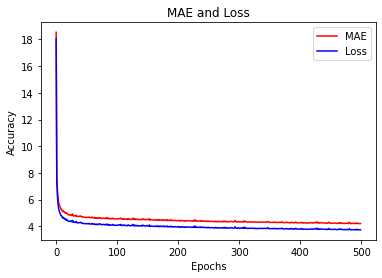

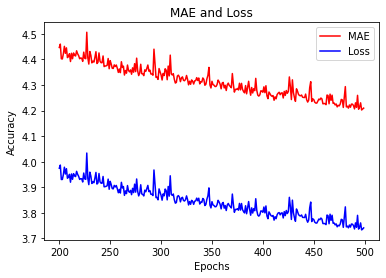

<Figure size 432x288 with 0 Axes>

In [23]:

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()